# CFB Machine Learning with Scikit-learn
A Jupyter notebook written by Katie Mummah (@nuclearkatie)

For CS539: Introduction to Artificial Neural Network and Fuzzy Systems

Fall 2018, University of Wisconsin-Madison

## Imports 

In [1]:
#general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.preprocessing import StandardScaler

#lime
from lime import lime_text
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing as preprocessing
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

In [2]:
#written by Katie Mummah
from src.data_util import load_clean, standard_dropped_columns
from src.train_test_util import split_remove_scale, remove_scale, assign_Xy, remove_teams, scaler
from src.test_classifier import test_predictions, plot_confusion_matrix
from src.lime_util import misclassified_games, lime_explainer, choose_misclassified

## Import and clean data

In [3]:
reg_season = load_clean('power5.csv', standard_dropped_columns())

Game scores found. Dropping them so they don't affect classifier 
 Data imported successfully


Split into feature vectors (X) and labels (y)

In [4]:
X_reg, y_reg = assign_Xy(reg_season)

Features and labels split successfully


### Split training and testing set
First randomize and pull out a small section of the training data to use for testing

Then remove and save the team names

Finally scale all features so feature vectors with much higher values don't have an outsized impact on the classification

In [5]:
X_train, X_test, y_train, y_test, home_train, away_train, home_test, away_test = split_remove_scale(reg_season,
                                                                                                   test_size=0.2)


Features and labels split successfully
Team names removed
Team names removed
Feature vectors scaled
Feature vectors scaled


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nuclearkatie/classes/cs539/project/src/train_test_util.py:69: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = scaler.transform(X)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nuclearkatie/classes/cs539/project/src/train_test_util.py:69: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = scaler.transform(X)


#  MLP classifier

In [6]:
from sklearn.neural_network import MLPClassifier

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10, 10, 10), max_iter=1000)  
mlp.fit(X_train, y_train.values.ravel())  

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10, 10, 10, 10, 10),
       learning_rate='constant', learning_rate_init=0.001, max_iter=1000,
       momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
       power_t=0.5, random_state=None, shuffle=True, solver='adam',
       tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Test MLP

In [8]:
mlp_predictions = mlp.predict(X_test)  

              precision    recall  f1-score   support

           0       0.81      0.74      0.77        62
           1       0.69      0.76      0.72        46

   micro avg       0.75      0.75      0.75       108
   macro avg       0.75      0.75      0.75       108
weighted avg       0.76      0.75      0.75       108

This set of predictions was 75.0% accurate

Confusion matrix, without normalization
[[46 16]
 [11 35]]


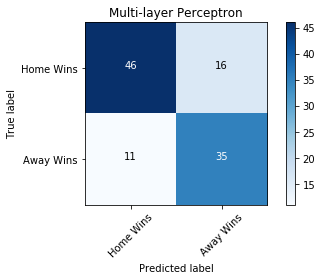

In [9]:
mlp_cm = test_predictions(y_test, mlp_predictions, title = 'Multi-layer Perceptron', plot_cm=True, cmap=plt.cm.Blues)

# SVM

In [10]:
from sklearn import svm

In [11]:
svm = svm.SVC(gamma='scale')
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Test SVM

In [12]:
svm_predictions = svm.predict(X_test)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        62
           1       0.70      0.67      0.69        46

   micro avg       0.74      0.74      0.74       108
   macro avg       0.74      0.73      0.73       108
weighted avg       0.74      0.74      0.74       108

This set of predictions was 74.07% accurate

Confusion matrix, without normalization
[[49 13]
 [15 31]]


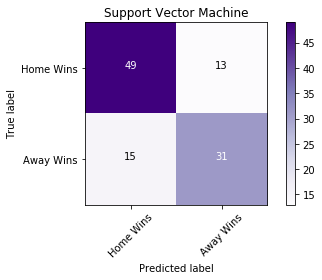

In [13]:
svm_cm = test_predictions(y_test, svm_predictions, title = 'Support Vector Machine', plot_cm=True, cmap=plt.cm.Purples)

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [15]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Test RF

In [16]:
rf_predictions = rf.predict(X_test)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        62
           1       0.69      0.72      0.70        46

   micro avg       0.74      0.74      0.74       108
   macro avg       0.74      0.74      0.74       108
weighted avg       0.74      0.74      0.74       108

This set of predictions was 74.07% accurate

Confusion matrix, without normalization
[[47 15]
 [13 33]]


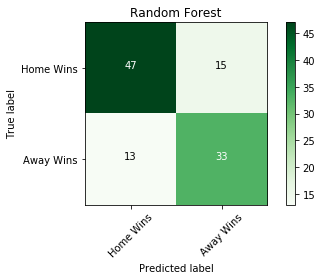

In [17]:
rf_cm = test_predictions(y_test, rf_predictions, title = 'Random Forest', plot_cm=True, cmap=plt.cm.Greens)

# Lime

Lime is a package that looks at an individual prediction and determines which feauture vectors were used to make the eventual classification. Here it is tested against a random game for each of the three classifiers
- MLP
- SVM
- Random Forest

### General lime

In [18]:
cols_reg = list(X_reg.columns.values) #Make a list of all of the columns in the df
cols_reg.pop(cols_reg.index('Home'))
cols_reg.pop(cols_reg.index('Away'))

'Away'

### Lime for MLP

- identify misclassified games

In [19]:
misclassified_games(X_test, y_test, home_test, away_test, mlp_predictions)

For Oregon State-Washington State, predicted winner Oregon State, but true winner is Washington State
For Iowa State-Oklahoma, predicted winner Iowa State, but true winner is Oklahoma
For Miami (OH)-Western Michigan, predicted winner Miami (OH), but true winner is Western Michigan
For South Alabama-Texas State, predicted winner Texas State, but true winner is South Alabama
For Minnesota-Purdue, predicted winner Purdue, but true winner is Minnesota
For Kansas State-Oklahoma State, predicted winner Oklahoma State, but true winner is Kansas State
For South Carolina-Missouri, predicted winner Missouri, but true winner is South Carolina
For Boise State-San Diego State, predicted winner Boise State, but true winner is San Diego State
For Navy-Memphis, predicted winner Memphis, but true winner is Navy
For Oklahoma State-Iowa State, predicted winner Oklahoma State, but true winner is Iowa State
For Michigan State-Purdue, predicted winner Purdue, but true winner is Michigan State
For Ball State

- Manual input if the user wants to examine a specific game. If not, choose the first game in testing set, which was randomized when the training/testing data were first split.

In [20]:
mlp_game = ['Minnesota','Purdue']; #example mlp_game=['Wisconsin','Minnesota'] but game _must_ be in testing suite.
# For a random game, leave mlp_game blank, i.e. mlp_game = []
if mlp_game:
    mlp_desired_game = choose_misclassified(X_test, home_test, away_test, mlp_game)
    target_names = np.array(mlp_game)
elif not mlp_game:
    mlp_desired_game = 1
    target_names = np.array(['Home wins', 'Away wins'])
    print("First game in testing set will be used")

In [21]:
mlp_explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train,
                                                   mode = "classification",
                                                   feature_names=cols_reg,
                                                   class_names = target_names,
                                                   discretize_continuous=True)

- use Lime to explain game

In [22]:
mlp_exp = mlp_explainer.explain_instance(X_test[mlp_desired_game], mlp.predict_proba,
                                         num_features= 15)

In [23]:
mlp_exp.show_in_notebook(show_table=True, show_all=True)

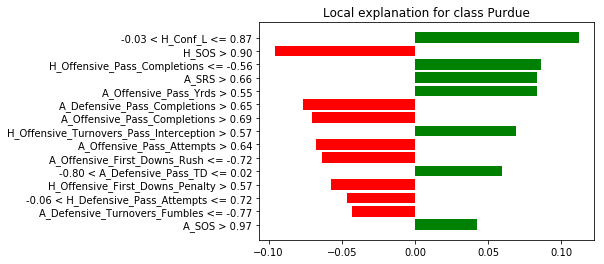

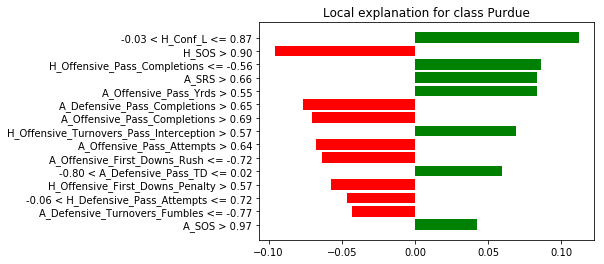

In [24]:
mlp_exp.as_pyplot_figure()

In [25]:
if mlp_game:
    mlp_exp.save_to_file('%s-%s_MLP.html' % (mlp_game[0], mlp_game[1]))

### Lime for SVM

- identify misclassified games

In [26]:
misclassified_games(X_test, y_test, home_test, away_test, svm_predictions)

For San Jose State-Nevada-Las Vegas, predicted winner Nevada-Las Vegas, but true winner is San Jose State
For Miami (OH)-Western Michigan, predicted winner Miami (OH), but true winner is Western Michigan
For South Alabama-Texas State, predicted winner Texas State, but true winner is South Alabama
For Minnesota-Purdue, predicted winner Purdue, but true winner is Minnesota
For Baylor-Texas Christian, predicted winner Baylor, but true winner is Texas Christian
For Florida State-Wake Forest, predicted winner Wake Forest, but true winner is Florida State
For South Carolina-Missouri, predicted winner Missouri, but true winner is South Carolina
For North Texas-Louisiana Tech, predicted winner North Texas, but true winner is Louisiana Tech
For Boise State-San Diego State, predicted winner Boise State, but true winner is San Diego State
For Navy-Memphis, predicted winner Memphis, but true winner is Navy
For Oklahoma State-Iowa State, predicted winner Oklahoma State, but true winner is Iowa Stat

### Lime for Random Forest

- identify misclassified games

In [27]:
misclassified_games(X_test, y_test, home_test, away_test, rf_predictions)

For San Jose State-Nevada-Las Vegas, predicted winner Nevada-Las Vegas, but true winner is San Jose State
For Iowa State-Oklahoma, predicted winner Iowa State, but true winner is Oklahoma
For Miami (OH)-Western Michigan, predicted winner Miami (OH), but true winner is Western Michigan
For South Alabama-Texas State, predicted winner Texas State, but true winner is South Alabama
For Akron-Bowling Green State, predicted winner Akron, but true winner is Bowling Green State
For Minnesota-Purdue, predicted winner Purdue, but true winner is Minnesota
For Georgia Southern-Appalachian State, predicted winner Appalachian State, but true winner is Georgia Southern
For Baylor-Texas Christian, predicted winner Baylor, but true winner is Texas Christian
For Florida State-Wake Forest, predicted winner Wake Forest, but true winner is Florida State
For South Carolina-Missouri, predicted winner Missouri, but true winner is South Carolina
For Boise State-San Diego State, predicted winner Boise State, but

In [28]:
rf_game = ['Illinois','Minnesota']; #example rf_game=['Wisconsin','Minnesota'] but game _must_ be in testing suite.
# For a random game, leave rf_game blank, i.e. rf_game = []
if rf_game:
    rf_desired_game = choose_misclassified(X_test, home_test, away_test, rf_game)
    target_names = np.array(rf_game)
elif not rf_game:
    rf_desired_game = 1
    target_names = np.array(['Home wins', 'Away wins'])
    print("First game in testing set will be used")

In [29]:
rf_explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train,
                                                   mode = "classification",
                                                   feature_names=cols_reg,
                                                   class_names = target_names,
                                                   discretize_continuous=True)

- use Lime to explain game

In [30]:
rf_exp = rf_explainer.explain_instance(X_test[rf_desired_game], rf.predict_proba,
                                         num_features= 15)

In [31]:
rf_exp.show_in_notebook(show_table=True, show_all=True)

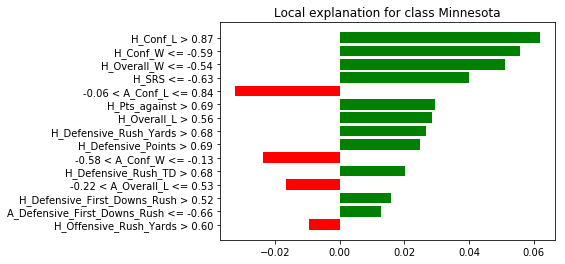

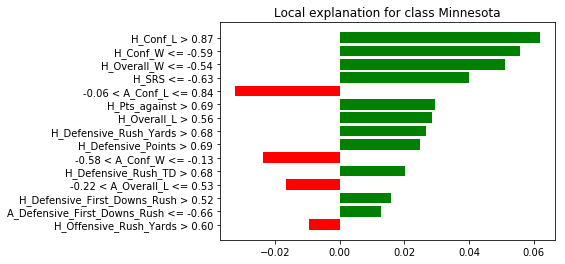

In [32]:
rf_exp.as_pyplot_figure()

In [33]:
if rf_game:
    rf_exp.save_to_file('%s-%s_RF.html' % (rf_game[0], rf_game[1]))

# Test Conference Championships
### data

In [34]:
conf = load_clean('conf_champs.csv', standard_dropped_columns())

No scores found. Data imported successfully


In [35]:
X_conf, y_conf, home_conf, away_conf = remove_scale(conf)

Features and labels split successfully
Team names removed
Feature vectors scaled


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nuclearkatie/classes/cs539/project/src/train_test_util.py:69: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = scaler.transform(X)


### Conference championship predictions

In [36]:
mlp_conf_predictions = mlp.predict(X_conf)
svm_conf_predictions = svm.predict(X_conf)
rf_conf_predictions = rf.predict(X_conf)

#### MLP

In [37]:
misclassified_games(X_conf, y_conf, home_conf, away_conf, mlp_conf_predictions)

For Ohio State-Northwestern, predicted winner Northwestern, but true winner is Ohio State
For Boise State-Fresno State, predicted winner Boise State, but true winner is Fresno State


              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.75      0.75      0.75         4

   micro avg       0.75      0.75      0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8

This set of predictions was 75.0% accurate

Confusion matrix, without normalization
[[3 1]
 [1 3]]


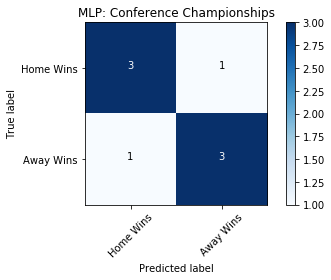

In [38]:
mlp_conf_cm = test_predictions(y_conf, mlp_conf_predictions, title = 'MLP: Conference Championships', 
                               plot_cm=True, cmap=plt.cm.Blues)

### SVM conference championship predictions

In [39]:
misclassified_games(X_conf, y_conf, home_conf, away_conf, svm_conf_predictions)

For Georgia-Alabama, predicted winner Georgia, but true winner is Alabama
For Boise State-Fresno State, predicted winner Boise State, but true winner is Fresno State
For Middle Tennessee State-UAB, predicted winner Middle Tennessee State, but true winner is UAB


              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.25      0.40         4

   micro avg       0.62      0.62      0.62         8
   macro avg       0.79      0.62      0.56         8
weighted avg       0.79      0.62      0.56         8

This set of predictions was 62.5% accurate

Confusion matrix, without normalization
[[4 0]
 [3 1]]


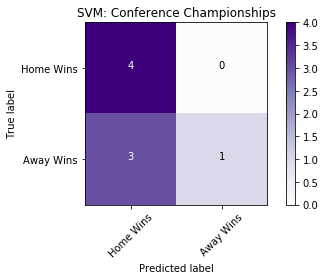

In [40]:
svm_conf_cm = test_predictions(y_conf, svm_conf_predictions, title = 'SVM: Conference Championships', 
                               plot_cm=True, cmap=plt.cm.Purples)

### RF conference championship predictions

In [41]:
misclassified_games(X_conf, y_conf, home_conf, away_conf, rf_conf_predictions)

For Georgia-Alabama, predicted winner Georgia, but true winner is Alabama
For Boise State-Fresno State, predicted winner Boise State, but true winner is Fresno State
For Middle Tennessee State-UAB, predicted winner Middle Tennessee State, but true winner is UAB


              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.25      0.40         4

   micro avg       0.62      0.62      0.62         8
   macro avg       0.79      0.62      0.56         8
weighted avg       0.79      0.62      0.56         8

This set of predictions was 62.5% accurate

Confusion matrix, without normalization
[[4 0]
 [3 1]]


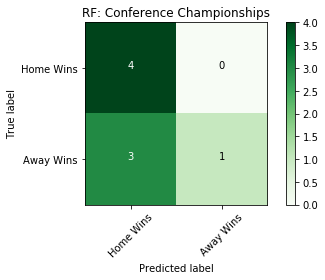

In [42]:
rf_conf_cm = test_predictions(y_conf, rf_conf_predictions, title = 'RF: Conference Championships', 
                               plot_cm=True, cmap=plt.cm.Greens)

# Ensemble (Voting) Classifier

In [43]:
from sklearn.ensemble import VotingClassifier

In [44]:
ensemble = VotingClassifier(estimators=[('mlp', mlp), ('svm', svm), ('rf', rf)], voting='hard')
ensemble = ensemble.fit(X_train, y_train)

In [45]:
ensemble_predictions = ensemble.predict(X_test)
ensemble_conference_predictions = ensemble.predict(X_conf)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        62
           1       0.72      0.72      0.72        46

   micro avg       0.76      0.76      0.76       108
   macro avg       0.75      0.75      0.75       108
weighted avg       0.76      0.76      0.76       108

This set of predictions was 75.93% accurate

Confusion matrix, without normalization
[[49 13]
 [13 33]]


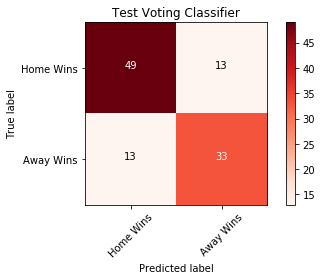

In [46]:
ensemble_cm = test_predictions(y_test, ensemble_predictions, title = 'Test Voting Classifier', 
                               plot_cm=True, cmap=plt.cm.Reds)

              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       1.00      0.25      0.40         4

   micro avg       0.62      0.62      0.62         8
   macro avg       0.79      0.62      0.56         8
weighted avg       0.79      0.62      0.56         8

This set of predictions was 62.5% accurate

Confusion matrix, without normalization
[[4 0]
 [3 1]]


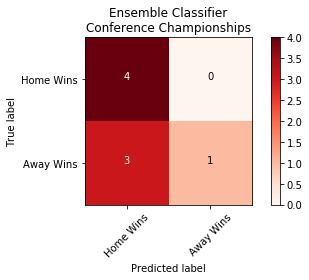

In [47]:
ensemble_conf_cm = test_predictions(y_conf, ensemble_conference_predictions, 
                                    title = "Ensemble Classifier\nConference Championships",
                                   plot_cm =True, cmap=plt.cm.Reds)

# Predict Bowl Games

In [48]:
bowl = load_clean('bowl_champs.csv', standard_dropped_columns())

No scores found. Data imported successfully


In [49]:
X_bowl = bowl.iloc[:, 0:(len(bowl.columns))]
X_bowl, bowl_home, bowl_away = remove_teams(X_bowl)
X_bowl = scaler(X_bowl)

Team names removed
Feature vectors scaled


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nuclearkatie/classes/cs539/project/src/train_test_util.py:69: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  X = scaler.transform(X)


### Bowl predictions

In [50]:
mlp_bowl = mlp.predict(X_bowl)
mlp_bowl

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0])

In [51]:
svm_bowl = svm.predict(X_bowl)
svm_bowl

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0])

In [52]:
rf_bowl = rf.predict(X_bowl)
rf_bowl

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0])

In [53]:
ensemble_bowl_predictions = ensemble.predict(X_bowl)
print(ensemble_bowl_predictions)

[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0
 0 0 1 1 0]


In [54]:
for bowl, home, away in zip(ensemble_bowl_predictions, bowl_home, bowl_away):
    if bowl == 0:
        predicted_winner = home
    else:
        predicted_winner = away

    print("For %s-%s, predicted winner %s" % (home, away, predicted_winner))

For Clemson-Notre Dame, predicted winner Clemson
For Alabama-Oklahoma, predicted winner Alabama
For Alabama-Clemson, predicted winner Alabama
For Alabama-Notre Dame, predicted winner Alabama
For Oklahoma-Clemson, predicted winner Clemson
For Oklahoma-Notre Dame, predicted winner Notre Dame
For Minnesota-Georgia Tech, predicted winner Georgia Tech
For Miami-Wisconsin, predicted winner Miami
For Purdue-Auburn, predicted winner Purdue
For West Virginia-Syracuse, predicted winner West Virginia
For Iowa State-Washington State, predicted winner Iowa State
For Florida-Michigan, predicted winner Florida
For South Carolina-Virginia, predicted winner South Carolina
For Stanford-Pitt, predicted winner Stanford
For Michigan State-Oregon, predicted winner Michigan State
For Missouri-Oklahoma State, predicted winner Missouri
For Northwestern-Utah, predicted winner Northwestern
For North Carolina State-Texas A&M, predicted winner North Carolina State
For Mississippi State-Iowa, predicted winner Missi